In [1]:
import numpy as np
import pandas as pd
import pylab as pl
import matplotlib.pyplot
from scipy import stats
import statsmodels.api as sm
import matplotlib.gridspec as gridspec
import os
import seaborn as sns
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
mta = np.load('MTA_Fare.npy')

In [3]:
#after reading the datacube you should see:
mta.shape

(600, 23, 194)

In [4]:
mta=mta.astype(float)
mta[mta==-1]=np.nan

# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.

In [5]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [6]:
#after I create a date range (for example with pd.date_range())
#in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
#all time series, each station each ride type, look like this (pretty ugly)
date = pd.date_range(start='05/21/2010',end='02/21/2014',freq='W')
date = date[2:]
date.shape

(194,)

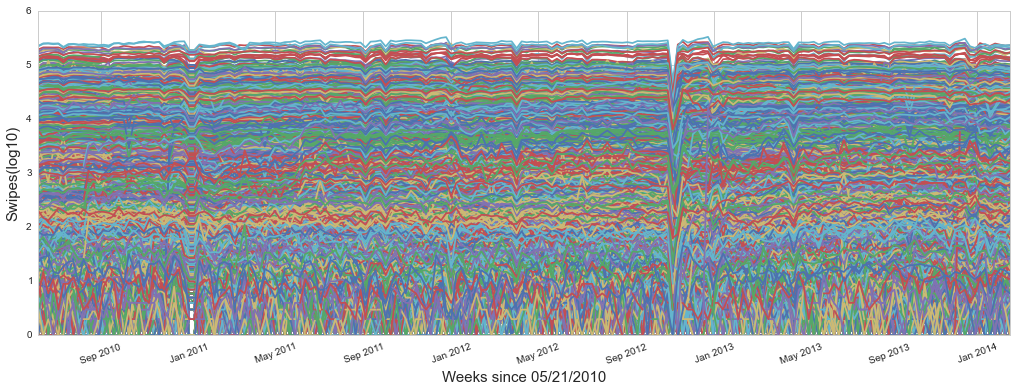

In [7]:
fig = figure(figsize=(15,5))
ax = fig.add_axes([0.1, 0.1, 0.9, 0.9])
ax.set_xlabel('Weeks since 05/21/2010', size=15)
ax.set_ylabel('Swipes(log10)', size=15)
ax.tick_params(axis='x',labelsize=5)
pl.xticks(rotation=20, fontsize=10)
for i in range(mta.shape[0]):
    for j in range(mta.shape[1]):
        ax.plot(date, np.log10(mta[i,j]))

## NOTE ON THE TREND DETECTION:
### you should find the ride type that has the steepest increase, and the steepest decrease. notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the flux near the beginning to the flux near the end of the time series.

### notice that you should inspect the time series, either algorithmically or by eye, to ensure you see a trend, and not just changing structure.

In [8]:
#as described in the instruction for some of the analysis 
#one can sum time series for all stations
mta_allsum = pd.DataFrame(np.nansum(mta, axis=0))
#or for all ride types
mta_allsum_rd = np.nansum(mta, axis=1)
print mta_allsum.shape
print mta_allsum_rd.shape

(23, 194)
(600, 194)


In [9]:
thresholds = [mta_allsum.loc[0,:].mean() + 3*mta_allsum.loc[0,:].std(), 
              mta_allsum.loc[0,:].mean() - 3*mta_allsum.loc[0,:].std()]
print thresholds

[16889312.352366973, 9595433.585777357]


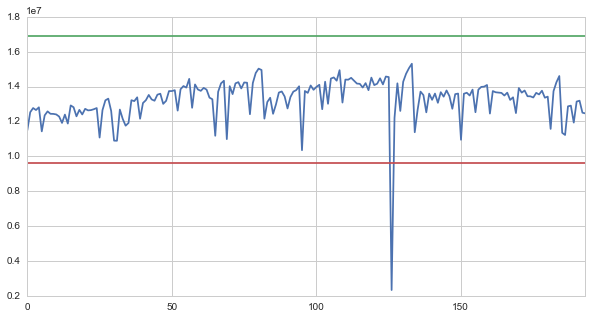

In [10]:
fig = figure(figsize=(10,5))
ax = mta_allsum.loc[0,:].plot()
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[0], thresholds[0]])
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[1], thresholds[1]])

In [11]:
fig = figure(figsize=(18,18))
for i in range(6):
    for j in range(4):
        if i*j<15:
            ax = fig.add_subplot(6,4,i*4+j+1)
            ax.plot(mta_allsum.loc[i*4+j,:])
            thresholds = [mta_allsum.loc[i*4+j,:].mean() + 3*mta_allsum.loc[i*4+j,:].std(), 
                          mta_allsum.loc[i*4+j,:].mean() - 3*mta_allsum.loc[i*4+j,:].std()]
            ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[0], thresholds[0]])
            ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[1], thresholds[1]])
            ax.set_title(ridetype[i*4+j])

In [12]:
# Event detection
evs = pd.Series()
for i in range(23):
    thresholds = [mta_allsum.loc[i,:].mean() + 3*mta_allsum.loc[i,:].std(), 
                  mta_allsum.loc[i,:].mean() - 3*mta_allsum.loc[i,:].std()]
    # event = pd.concat([ev, pd.Series(date[mta_allsum.index[mta_allsum.loc[i,:]<thresholds[1]]])], axis=0, ignore_index=True)
    ev = (mta_allsum.loc[i,:]<thresholds[1])
    evs = pd.concat([evs, pd.Series(date[ev.index[ev==True]])], axis=0, ignore_index=True)

/Users/Faye/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  if __name__ == '__main__':


(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

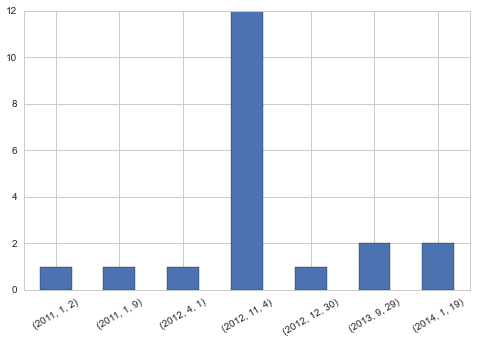

In [13]:
evs.sort()
evs.groupby([evs.dt.year, evs.dt.month, evs.dt.day]).count().plot(kind="bar",fontsize=10, figsize=(8,5))
pl.xticks(rotation=30)

# Task 2: 
### Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

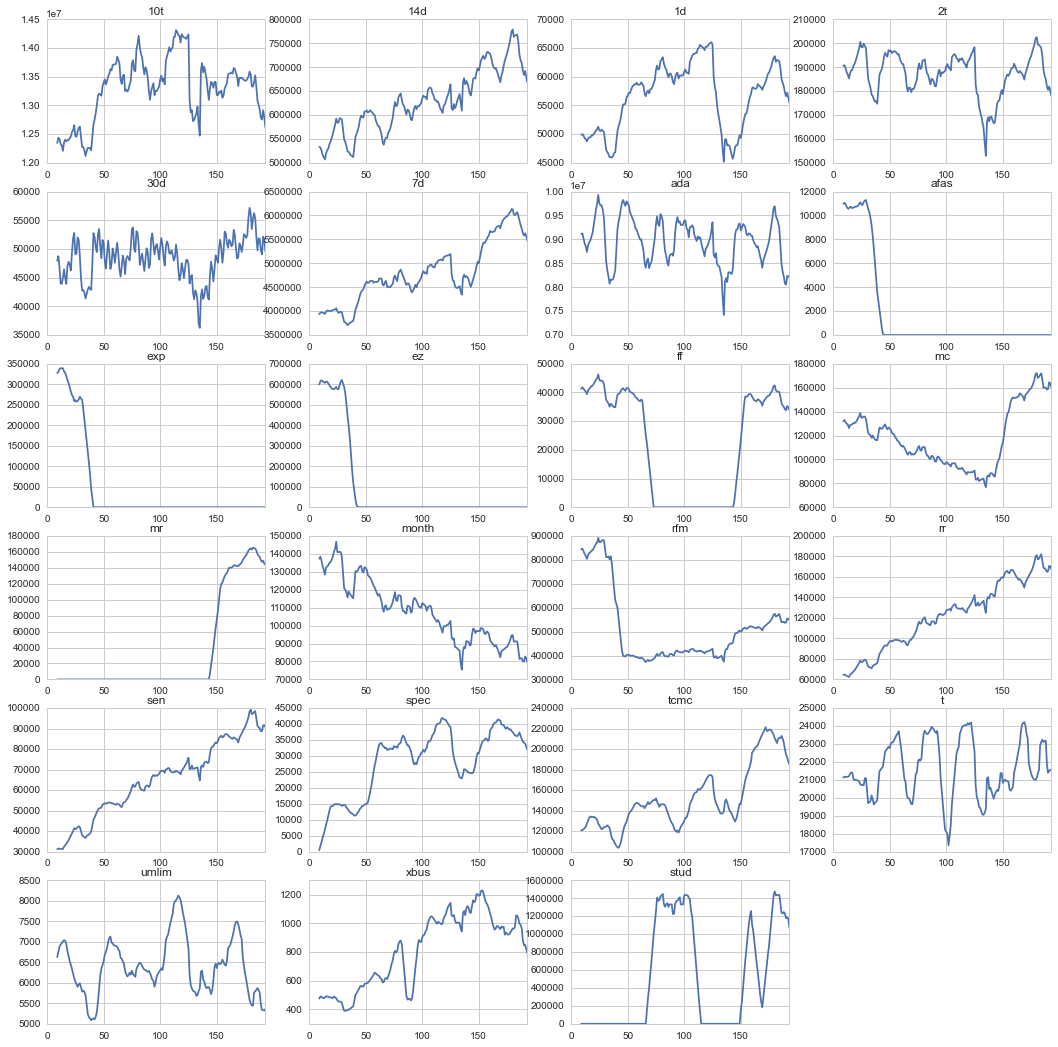

In [14]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(18,18))
ratio = np.zeros(23)
std = np.zeros(23)
for i in range(6):
    for j in range(4):
        if i*j<15:
            ax = fig.add_subplot(6,4,i*4+j+1)
            roll_mean = pd.rolling_mean(mta_allsum.loc[i*4+j,:], 10)
            ax = roll_mean.plot()
            ratio[i*4+j] = roll_mean.loc[9]/roll_mean.loc[193]
            std[i*4+j] = np.nanstd(roll_mean)
            ax.set_title(ridetype[i*4+j])


In [19]:
ridetype_ratio_std = pd.DataFrame({'Type' : ridetype, 'Flux Ratio From Beginning to End' : ratio, 'Std' : std})

In [20]:
ridetype_ratio_std

,Flux Ratio From Beginning to End,Std,Type
0,0.978667,546777.616992,10t
1,0.798681,64593.901400,14d
2,0.899810,5767.412494,1d
3,1.070889,8828.003856,2t
4,0.967317,3624.088526,30d
5,0.719555,631955.017784,7d
6,1.111307,473487.373171,ada
7,4774.478261,3794.926774,afas
8,93571.342857,101444.891854,exp
9,665798.555556,206370.776156,ez


# Task 3:
### Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

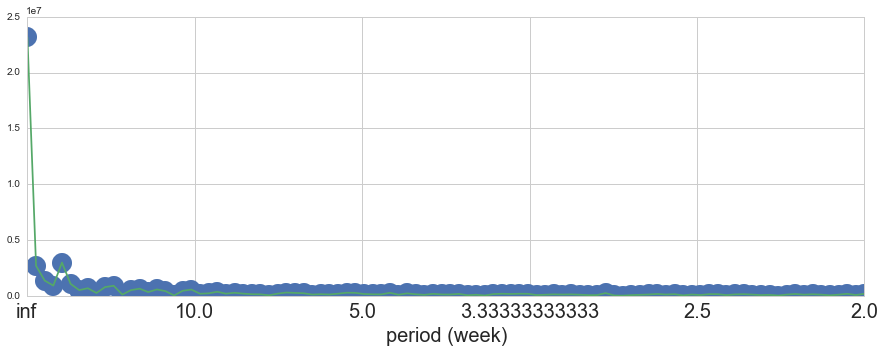

In [22]:
mta_allsum =pd.DataFrame(np.nansum(mta, axis=1))
f = np.abs(np.fft.rfft(mta_allsum.loc[0,:]))
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)
sample_rate = 1
ax.plot(np.fft.rfftfreq(194, 1.0), (f), 'o', ms=20)
ax.plot(np.fft.rfftfreq(194, 1.0), (f), '-')
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
pl.xlabel("period (week)", fontsize=20)

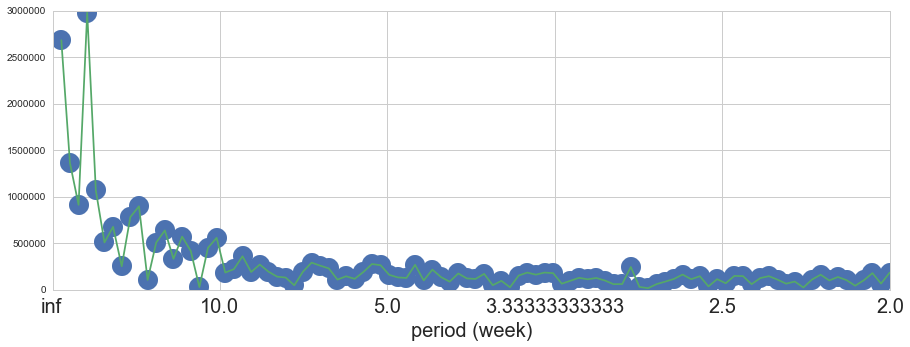

In [47]:
f = np.abs(np.fft.rfft(mta_allsum.loc[0,:]))
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)
sample_rate = 1.0
ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], 'o', ms=20)
ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], '-')
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
pl.xlabel("period (week)", fontsize=20)

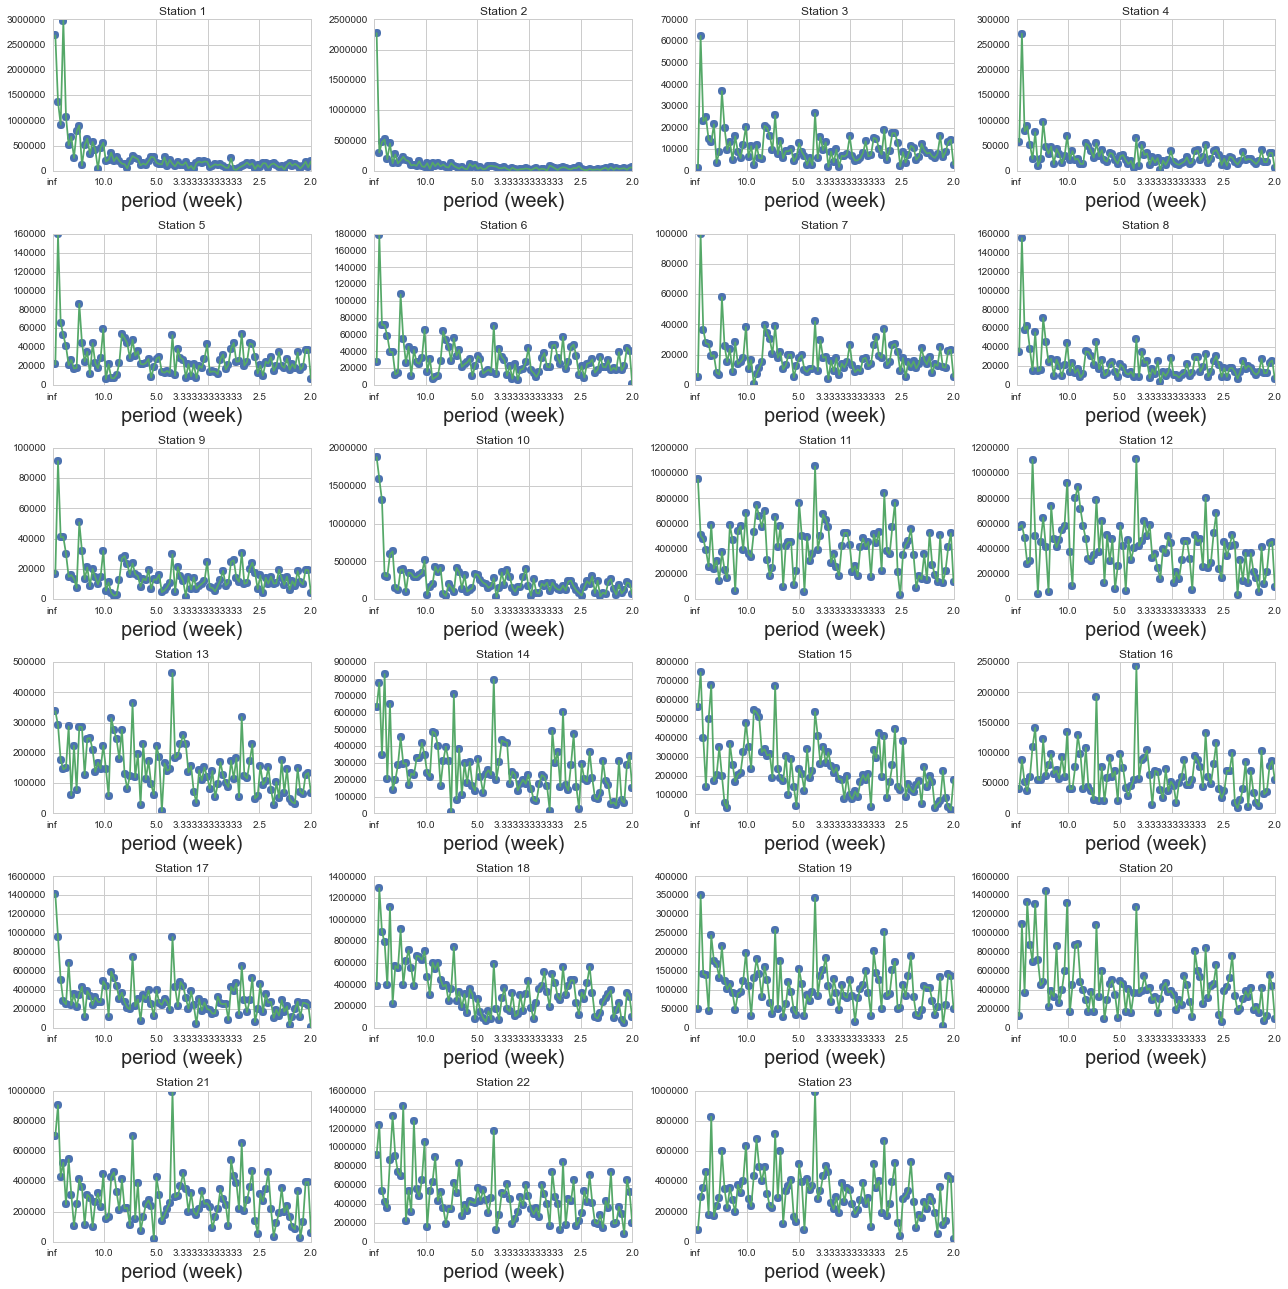

In [27]:
fig = plt.figure(figsize=(18,18))
for i in range(6):
    for j in range(4):
        if i*j<15:
            ax = fig.add_subplot(6,4,i*4+j+1)
            f = np.abs(np.fft.rfft(mta_allsum.loc[i*4+j,:]))
            ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], 'o', ms=8)
            ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], '-')
            ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=10)
            pl.xlabel("period (week)", fontsize=20)
            ax.set_title("Station %d"%(i*4+j+1))
fig.tight_layout()

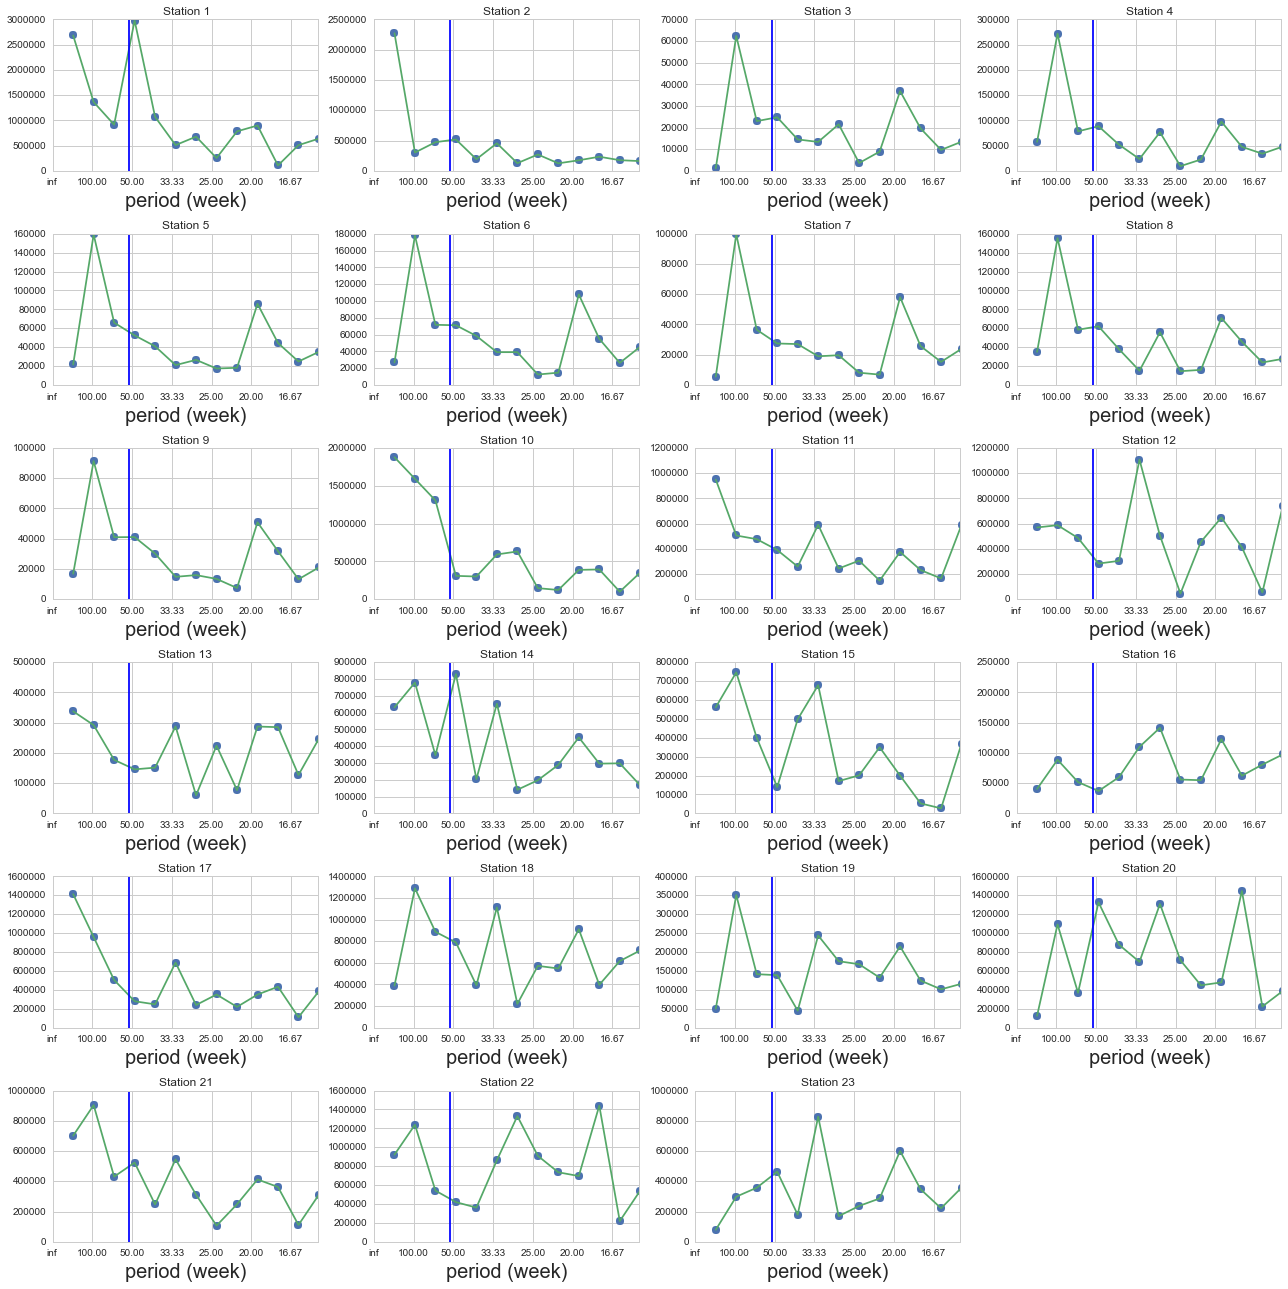

In [26]:
fig = plt.figure(figsize=(18,18))
annual = np.zeros(600)
for i in range(6):
    for j in range(4):
        if i*j<15:
            ax = fig.add_subplot(6,4,i*4+j+1)
            f = np.abs(np.fft.rfft(mta_allsum.loc[i*4+j,:]))
            ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], 'o', ms=8)
            ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], '-')
            ax.set_xlim(0,1.0/15)
            ax.set_xticklabels([ "%.2f"%(1/f) for f in ax.get_xticks()], fontsize=10)
            pl.xlabel("period (week)", fontsize=20)
            plt.axvline(1.0/52)
            ax.set_title("Station %d"%(i*4+j+1))
fig.tight_layout()

In [33]:
# Find the index of the frequency which is closest to 1/52 weeks.
freq = np.fft.rfftfreq(194, 1.0)
index_52week = max([m for m, n in enumerate(freq) if n <= 1.0/52])
print 1.0/freq[index_52week]
index_52week += 1
print 1.0/freq[index_52week]
f = np.abs(np.fft.rfft(mta_allsum_rd[0]))
f[index_52week]

64.6666666667
48.5


2980160.6355953491

In [34]:
power = []
power_2 = []
for i in range(600):
    f = np.abs(np.fft.rfft(mta_allsum_rd[i,:]))
    power.append(f[index_52week])
    power_2.append(f[index_52week])
power_2.sort(reverse=True)

In [37]:
station_most_power = [m for m, n in enumerate(power) if n == 2980160.6355953491 or n == 2950388.929214194 or n == 2931895.8769513383 or n ==2402218.5809588572]
print station_most_power

[0, 150, 194, 327]


### There were a increasing trend in ride type '14d','7d','ff','sen' and a decreasing trend in ride type 'month'.
### The drop of MTA swipes was the week of October 30, 2012 caused by the Hurricane Sandy which made the MTA service stopped.
### [0, 150, 194, 327] are important event time.

## EXTRA CREDIT: Cluster. 
### Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis). 
### Since this is extra credit I will leave it to you to figure out the details, but for KMeans for e.g. if you use the sklearn.cluster package it would look something like:

In [44]:
from sklearn.cluster import KMeans

In [42]:
### i am flattening the first 2 dimensions of the cube to cluster all light curves for all stations and all types
tots = mta.transpose(2,0,1).reshape(mta.shape[2], mta.shape[1]*mta.shape[0]).T

In [45]:
### removing empty light curves
tots = tots[tots.std(1)>0]

### with Kmeans you have to choose the number of clusters ahead 
km = KMeans(n_clusters=10)

### and standardize the lightcurves before clustering
vals = ((tots.T - tots.mean(1))/tots.std(1)).T

### then you can run:
km.fit(vals)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=10, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)